In [32]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [33]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [34]:
df.dropna(inplace=True)
pickup_dt = df.pickup_datetime.dt

In [35]:
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace = True)

df['distance'] = np.abs(df.pickup_longitude-df.dropoff_longitude)+np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude"], inplace=True)

df = df[(df.distance > 0) & (df.fare_amount >0)]

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [36]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14705, 6), (3677, 6), (14705,), (3677,))

## Training 

In [37]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [38]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [39]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform="yeo-johnson"), ["passenger_count","year","distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month", "day", "hour"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\ACER\miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.0003055765040196876, 'algo__fit_intercept': False, 'algo__l1_ratio': 0.23763754399239972, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7668080230187375 0.7620732372981962 0.7510993401248129


C:\Users\ACER\miniconda3\envs\jcopml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+05, tolerance: 3.172e+02
  model = cd_fast.enet_coordinate_descent(


## Feature Importance 

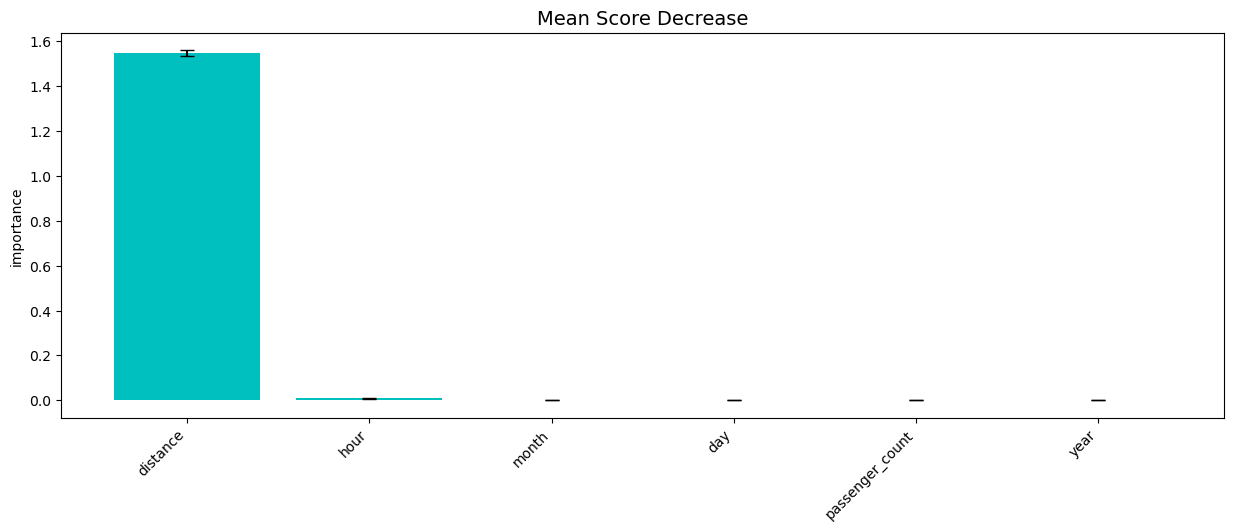

In [40]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

## Evaluation

In [41]:
from jcopml.plot import plot_residual

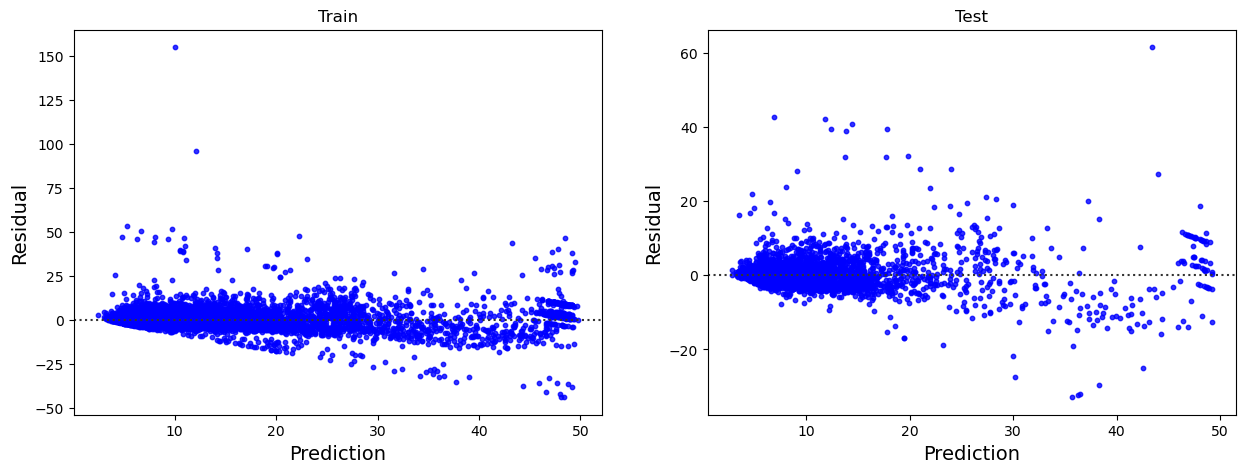

In [42]:
plot_residual(X_train, y_train, X_test, y_test, model)

Masih ada unbalanced, cek datanya

In [43]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1483,1.0,2009,8,4,21,0.000416,165.00,154.948494
14142,1.0,2014,12,4,10,0.045860,108.00,95.879127
2432,1.0,2012,11,4,1,0.003817,58.60,53.277030
18807,2.0,2013,8,5,2,0.038527,61.25,51.509685
5970,1.0,2014,3,3,18,0.003541,57.33,50.669573
1494,1.0,2009,9,1,14,0.000031,70.00,47.748783
5078,5.0,2013,1,1,13,0.006011,52.00,47.191037
13280,1.0,2009,6,0,21,0.029244,55.00,46.910875
7810,2.0,2011,10,0,8,0.321534,95.00,46.479436
18530,1.0,2014,5,0,14,0.037768,57.33,46.374486
